Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from abides_core import abides
from abides_core.utils import parse_logs_df, ns_date, str_to_ns, fmt_ts
from abides_markets.configs import rmsc04

## Build Configuration Combos


Here we are generating/building a config from the config file rmsc04. 
The config object is a dictionnary containing key elements like, start time, end time, agents to be used, latency and computation delay models.

In [2]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from abides_core.utils import get_wake_time, str_to_ns
from abides_markets.agents import (
    ExchangeAgent,
    NoiseAgent,
    ValueAgent,
    AdaptiveMarketMakerAgent,
    MomentumAgent,
)
from abides_markets.models import OrderSizeModel
from abides_markets.oracles import SparseMeanRevertingOracle
from abides_markets.utils import generate_latency_model


In [53]:
######## genegrate different combinations of configs
# - [1,2,3,4,5]     Exchange Agent
# - [1,2,3,4,5]     Adaptive Market Maker Agents
# - [50,100,150,200,250,300]   Value Agents
# - [6,12,24,36,48]    Momentum Agents
# - [100,500,1000,1500,2000]  Noise Agents

import pandas as pd
import itertools

def generate_parameter_combinations():
    exchange_agent_choices = [1]
    adaptive_market_maker_choices = [1]
    value_agent_choices = [50,100,200,300]
    momentum_agent_choices = [6,12,24,36,48]
    noise_agent_choices = [100,500,1000,1500,2000]
    
    all_combinations = list(itertools.product(exchange_agent_choices, adaptive_market_maker_choices, value_agent_choices, momentum_agent_choices,
                                              noise_agent_choices))
    df = pd.DataFrame(all_combinations, columns=['ExchangeAgent', 'AdaptiveMarketMakerAgents', 'ValueAgent', 'MomentumAgent', 'NoiseAgent'])
    
    return df

In [54]:
df_combinations = generate_parameter_combinations()
df_combinations.head()

,ExchangeAgent,AdaptiveMarketMakerAgents,ValueAgent,MomentumAgent,NoiseAgent
0,1,1,50,6,100
1,1,1,50,6,500
2,1,1,50,6,1000
3,1,1,50,6,1500
4,1,1,50,6,2000


In [55]:
########################################################################################################################
############################################### GENERAL CONFIG #########################################################

def build_config_mix(
    seed=int(datetime.now().timestamp() * 1_000_000) % (2 ** 32 - 1),
    date="20210205",
    end_time="10:00:00",
    stdout_log_level="INFO",
    ticker="ABM",
    starting_cash=10_000_000,  # Cash in this simulator is always in CENTS.
    log_orders=True,  # if True log everything
    # 1) Exchange Agent
    book_logging=True,
    book_log_depth=10,
    stream_history_length=500,
    exchange_log_orders=None,
    # 2) Noise Agent
    num_noise_agents=1000,
    # 3) Value Agents
    num_value_agents=102,
    r_bar=100_000,  # true mean fundamental value
    kappa=1.67e-15,  # Value Agents appraisal of mean-reversion
    lambda_a=5.7e-12,  # ValueAgent arrival rate
    # oracle
    kappa_oracle=1.67e-16,  # Mean-reversion of fundamental time series.
    sigma_s=0,
    fund_vol=5e-10,  # Volatility of fundamental time series.
    megashock_lambda_a=2.77778e-18,
    megashock_mean=1000,
    megashock_var=50_000,
    # 4) Market Maker Agents
    # each elem of mm_params is tuple (window_size, pov, num_ticks, wake_up_freq, min_order_size)
    mm_window_size="adaptive",
    mm_pov=0.025,
    mm_num_ticks=10,
    mm_wake_up_freq="60S",
    mm_min_order_size=1,
    mm_skew_beta=0,
    mm_price_skew=4,
    mm_level_spacing=5,
    mm_spread_alpha=0.75,
    mm_backstop_quantity=0,
    mm_cancel_limit_delay=50,  # 50 nanoseconds
    # 5) Momentum Agents
    num_momentum_agents=12,
):
    """
    create the background configuration 
    These are all the non-learning agent that will run in the simulation
    :param seed: seed of the experiment
    :type seed: int
    :param log_orders: debug mode to print more
    :return: all agents of the config
    :rtype: list
    """

    # fix seed
    np.random.seed(seed)

    def path_wrapper(pomegranate_model_json):
        """
        temporary solution to manage calls from abides-gym or from the rest of the code base
        TODO:find more general solution
        :return:
        :rtype:
        """
        # get the  path of the file
        path = os.getcwd()
        if path.split("/")[-1] == "abides_gym":
            return "../" + pomegranate_model_json
        else:
            return pomegranate_model_json

    mm_wake_up_freq = str_to_ns(mm_wake_up_freq)

    # order size model
    ORDER_SIZE_MODEL = OrderSizeModel()  # Order size model
    # market marker derived parameters
    MM_PARAMS = [
        (mm_window_size, mm_pov, mm_num_ticks, mm_wake_up_freq, mm_min_order_size),
        (mm_window_size, mm_pov, mm_num_ticks, mm_wake_up_freq, mm_min_order_size),
    ]
    NUM_MM = len(MM_PARAMS)
    # noise derived parameters
    SIGMA_N = r_bar / 100  # observation noise variance

    # date&time
    DATE = int(pd.to_datetime(date).to_datetime64())
    MKT_OPEN = DATE + str_to_ns("09:30:00")
    MKT_CLOSE = DATE + str_to_ns(end_time)
    # These times needed for distribution of arrival times of Noise Agents
    NOISE_MKT_OPEN = MKT_OPEN - str_to_ns("00:30:00")
    NOISE_MKT_CLOSE = DATE + str_to_ns("16:00:00")

    # oracle
    symbols = {
        ticker: {
            "r_bar": r_bar,
            "kappa": kappa_oracle,
            "sigma_s": sigma_s,
            "fund_vol": fund_vol,
            "megashock_lambda_a": megashock_lambda_a,
            "megashock_mean": megashock_mean,
            "megashock_var": megashock_var,
            "random_state": np.random.RandomState(
                seed=np.random.randint(low=0, high=2 ** 32)
            ),
        }
    }

    oracle = SparseMeanRevertingOracle(MKT_OPEN, NOISE_MKT_CLOSE, symbols)

    # Agent configuration
    agent_count, agents, agent_types = 0, [], []

    agents.extend(
        [
            ExchangeAgent(
                id=0,
                name="EXCHANGE_AGENT",
                type="ExchangeAgent",
                mkt_open=MKT_OPEN,
                mkt_close=MKT_CLOSE,
                symbols=[ticker],
                book_logging=book_logging,
                book_log_depth=book_log_depth,
                log_orders=exchange_log_orders,
                pipeline_delay=0,
                computation_delay=0,
                stream_history=stream_history_length,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
        ]
    )
    agent_types.extend("ExchangeAgent")
    agent_count += 1

    agents.extend(
        [
            NoiseAgent(
                id=j,
                name="NoiseAgent {}".format(j),
                type="NoiseAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                wakeup_time=get_wake_time(NOISE_MKT_OPEN, NOISE_MKT_CLOSE),
                log_orders=log_orders,
                order_size_model=ORDER_SIZE_MODEL,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
            for j in range(agent_count, agent_count + num_noise_agents)
        ]
    )
    agent_count += num_noise_agents
    agent_types.extend(["NoiseAgent"])

    agents.extend(
        [
            ValueAgent(
                id=j,
                name="Value Agent {}".format(j),
                type="ValueAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                sigma_n=SIGMA_N,
                r_bar=r_bar,
                kappa=kappa,
                lambda_a=lambda_a,
                log_orders=log_orders,
                order_size_model=ORDER_SIZE_MODEL,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
            for j in range(agent_count, agent_count + num_value_agents)
        ]
    )
    agent_count += num_value_agents
    agent_types.extend(["ValueAgent"])

    agents.extend(
        [
            AdaptiveMarketMakerAgent(
                id=j,
                name="ADAPTIVE_POV_MARKET_MAKER_AGENT_{}".format(j),
                type="AdaptivePOVMarketMakerAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                pov=MM_PARAMS[idx][1],
                min_order_size=MM_PARAMS[idx][4],
                window_size=MM_PARAMS[idx][0],
                num_ticks=MM_PARAMS[idx][2],
                wake_up_freq=MM_PARAMS[idx][3],
                poisson_arrival=True,
                cancel_limit_delay=mm_cancel_limit_delay,
                skew_beta=mm_skew_beta,
                price_skew_param=mm_price_skew,
                level_spacing=mm_level_spacing,
                spread_alpha=mm_spread_alpha,
                backstop_quantity=mm_backstop_quantity,
                log_orders=log_orders,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
            for idx, j in enumerate(range(agent_count, agent_count + NUM_MM))
        ]
    )
    agent_count += NUM_MM
    agent_types.extend("POVMarketMakerAgent")

    agents.extend(
        [
            MomentumAgent(
                id=j,
                name="MOMENTUM_AGENT_{}".format(j),
                type="MomentumAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                min_size=1,
                max_size=10,
                wake_up_freq=str_to_ns("37s"),
                poisson_arrival=True,
                log_orders=log_orders,
                order_size_model=ORDER_SIZE_MODEL,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
            for j in range(agent_count, agent_count + num_momentum_agents)
        ]
    )
    agent_count += num_momentum_agents
    agent_types.extend("MomentumAgent")

    # extract kernel seed here to reproduce the state of random generator in old version
    random_state_kernel = np.random.RandomState(
        seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
    )
    # LATENCY
    latency_model = generate_latency_model(agent_count)

    default_computation_delay = 50  # 50 nanoseconds

    ##kernel args
    kernelStartTime = DATE
    kernelStopTime = MKT_CLOSE + str_to_ns("1s")

    return {
        "seed": seed,
        "start_time": kernelStartTime,
        "stop_time": kernelStopTime,
        "agents": agents,
        "agent_latency_model": latency_model,
        "default_computation_delay": default_computation_delay,
        "custom_properties": {"oracle": oracle},
        "random_state_kernel": random_state_kernel,
        "stdout_log_level": stdout_log_level,
    }


## Try different configs for simulation and calculate the metrics

Metrics:

Mid Price volatility: the degree of fluctuation in the prices of assets in the market over time.

Average Bid-ask spread: the difference between the highest price a buyer is willing to pay for an asset and the lowest price a seller is willing to accept for the same asset.

Total Trading volume: the amount of trading activity in the market over a given period of time.

Average Order book imbalance: the difference between the total amount of buy orders and sell orders in the order book.

Relative Strength Index(RSI): a trading momentum indicator that averages the price gains and losses during a specific trading period to see if the stock is more likely to keep going up/down or change its direction.



In [56]:
# iterate through df_combinations and take each row as a config
df_result = pd.DataFrame()
for index, row in df_combinations.iterrows():
    num_noise_agents = row['NoiseAgent']
    num_value_agents = row['ValueAgent']
    num_momentum_agents = row['MomentumAgent']
    
    # Pass the parameters to the function
    config = build_config_mix(num_noise_agents=num_noise_agents, num_value_agents=num_value_agents, num_momentum_agents=num_momentum_agents)

    # Run the simulation
    end_state = abides.run( config )
    order_book = end_state["agents"][0].order_books["ABM"]
    L1 = order_book.get_L1_snapshots()

    # get best ask and best bid price & quantity
    best_bids = pd.DataFrame(L1["best_bids"],columns=["time","price","qty"])
    best_asks = pd.DataFrame(L1["best_asks"],columns=["time","price","qty"])

    ## All times are in ns from 1970, remove the date component to put them in ns from midnight
    best_bids["time"] = best_bids["time"].apply( lambda x: x - ns_date(x) )
    best_asks["time"] = best_asks["time"].apply( lambda x: x - ns_date(x) )

    # merge and calculate metrics
    df_merged = pd.merge(best_asks,best_bids,on='time')
    df_merged['mid_price'] = (df_merged['price_x']+df_merged['price_y'])/2
    df_merged['mid_price_move'] = df_merged['mid_price'] - df_merged['mid_price'].shift(1)
    df_merged['spread'] = df_merged['price_x']-df_merged['price_y']
    df_merged['misbalance'] = df_merged['qty_x']-df_merged['qty_y']
    df_merged['imbalance'] = df_merged['qty_y']/(df_merged['qty_x']+df_merged['qty_y'])
    df_merged['return'] = df_merged['mid_price']/df_merged['mid_price'].shift()

    df_merged['gain'] = 0
    df_merged['loss'] = 0
    df_merged.loc[df_merged['mid_price_move'] < 0, 'loss'] = -1*df_merged['mid_price_move']
    df_merged.loc[df_merged['mid_price_move'] > 0, 'gain'] = df_merged['mid_price_move']

    #rename
    column_map = {'price_x': 'best_ask', 'qty_x': 'qty_ask', 'price_y': 'best_bid', 'qty_y': 'qty_bid'}
    df_merged = df_merged.rename(columns=column_map)

    # calculate aggregated metrics
    mid_price_avg = df_merged['mid_price'].mean()
    mid_price_vola = df_merged['mid_price'].std()*252**.5
    spread_avg = df_merged['spread'].mean()
    qty_total = (df_merged['qty_bid']+df_merged['qty_ask']).sum()
    imbalance_avg = df_merged['imbalance'].mean()
    misbalance_avg = df_merged['misbalance'].mean()
    avg_gain = np.mean(df_merged['gain'])/10000
    avg_loss = np.mean(df_merged['loss'])/10000
    while avg_gain == 0:
            avg_gain = 1
    while avg_loss == 0:
        avg_loss = 1
    rs = avg_gain / avg_loss
    rsi = 100-100/1+rs

    
    # append to dataframe
    row['mid_price_avg'] = mid_price_avg
    row['mid_price_vola'] = mid_price_vola
    row['spread_avg'] = spread_avg
    row['qty_total'] = qty_total
    row['imbalance_avg'] = imbalance_avg
    row['misbalance_avg'] = misbalance_avg
    row['rsi'] = rsi

    df_result = df_result.append(row)



[89829] INFO abides Simulation Start Time: 2023-02-26 03:17:36.164417
[89829] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
[89829] INFO abides_core.kernel Event Queue elapsed: 0:00:00.378799, messages: 5,576, messages per second: 14720.2
[89829] INFO abides_core.kernel Mean ending value by agent type:
[89829] INFO abides_core.kernel NoiseAgent: -595
[89829] INFO abides_core.kernel ValueAgent: 1261
[89829] INFO abides_core.kernel AdaptivePOVMarketMakerAgent: 0
[89829] INFO abides_core.kernel MomentumAgent: -589
[89829] INFO abides_core.kernel Simulation ending!
[89829] INFO abides Simulation End Time: 2023-02-26 03:17:36.664291
[89829] INFO abides Time taken to run simulation: 0:00:00.499874
[89829] INFO abides Simulation Start Time: 2023-02-26 03:17:36.784578
[89829] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
[89829] INFO abides_core.kernel

In [57]:
#save the results
import openpyxl
df_result.to_excel('combinations_comparison1.xlsx', index=False)

## Evaluations

### Mid Price Volatility

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

/Users/aprilyang/Desktop/Capstone/abides-jpmc/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


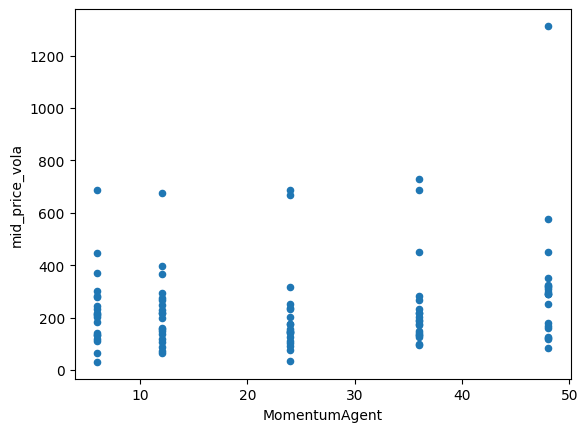

In [60]:
df_result.plot(x='MomentumAgent', y='mid_price_vola', kind='scatter')
plt.show()

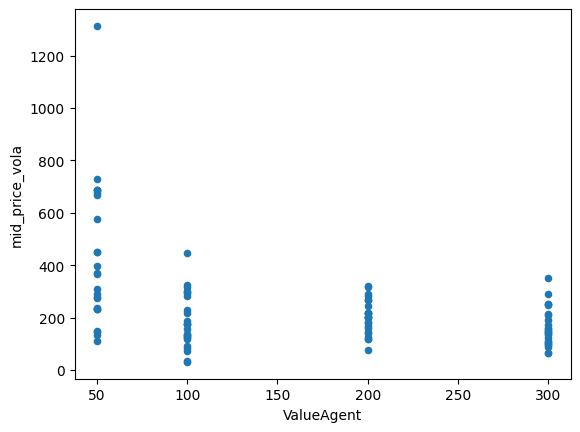

In [61]:
df_result.plot(x='ValueAgent', y='mid_price_vola', kind='scatter')
plt.show()

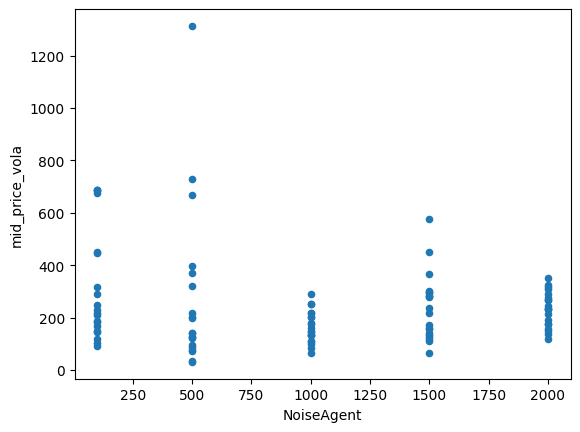

In [62]:
df_result.plot(x='NoiseAgent', y='mid_price_vola', kind='scatter')
plt.show()

### Average Mid Price

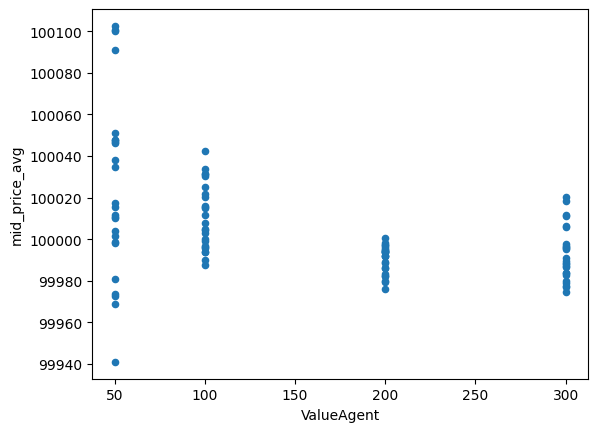

In [63]:
df_result.plot(x='ValueAgent', y='mid_price_avg', kind='scatter')
plt.show()

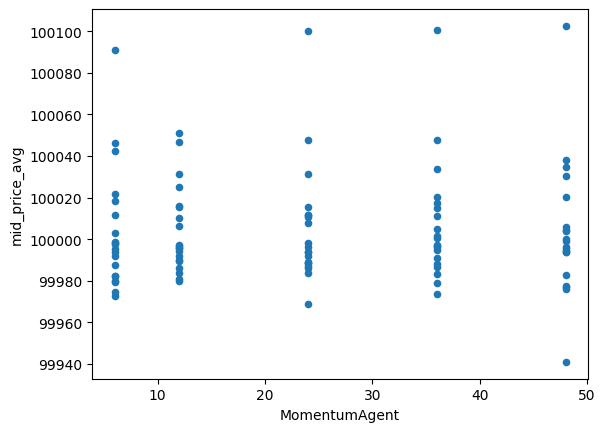

In [64]:
df_result.plot(x='MomentumAgent', y='mid_price_avg', kind='scatter')
plt.show()

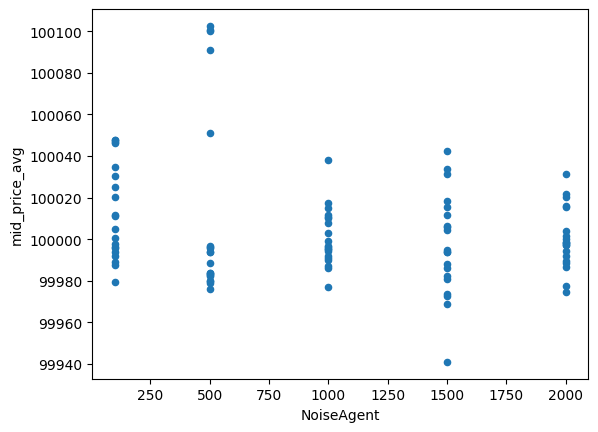

In [65]:
df_result.plot(x='NoiseAgent', y='mid_price_avg', kind='scatter')
plt.show()

### Total Quantity(best bid + best ask)


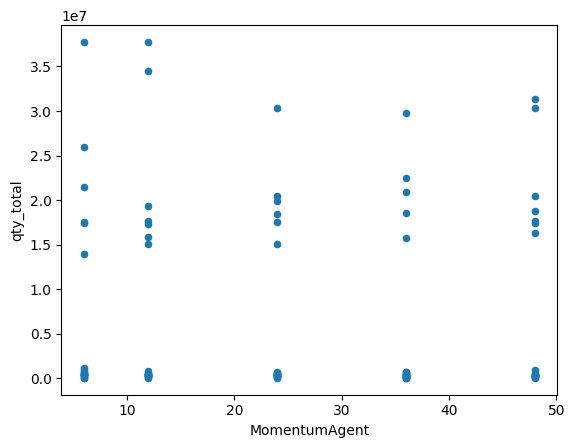

In [66]:
df_result.plot(x='MomentumAgent', y='qty_total', kind='scatter')
plt.show()

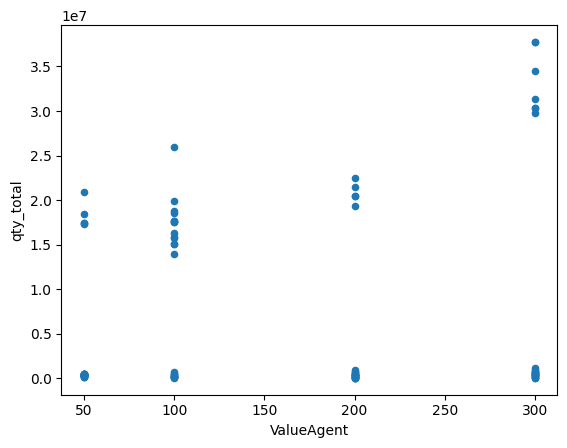

In [67]:
df_result.plot(x='ValueAgent', y='qty_total', kind='scatter')
plt.show()

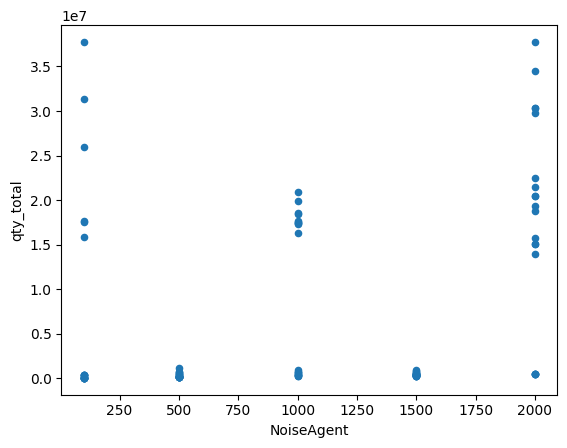

In [68]:
df_result.plot(x='NoiseAgent', y='qty_total', kind='scatter')
plt.show()

### Average Spread

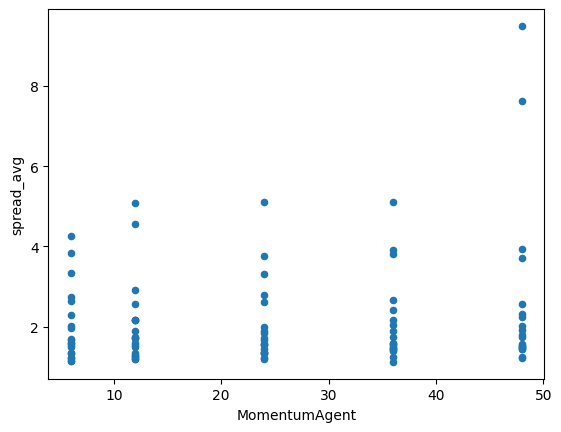

In [69]:
df_result.plot(x='MomentumAgent', y='spread_avg', kind='scatter')
plt.show()

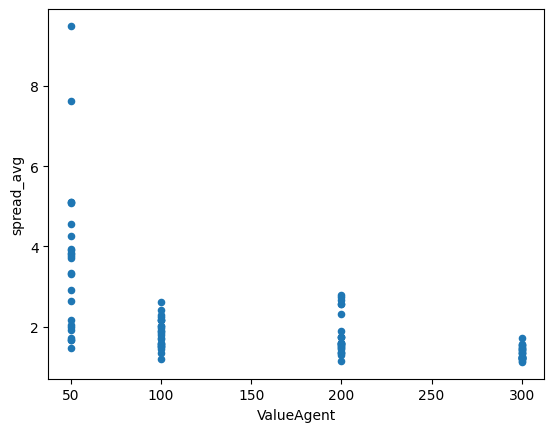

In [70]:
df_result.plot(x='ValueAgent', y='spread_avg', kind='scatter')
plt.show()

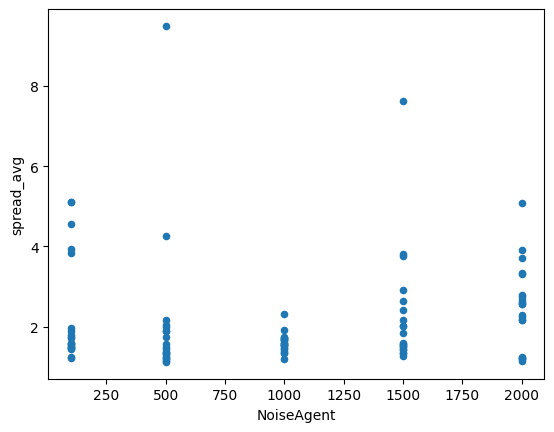

In [71]:
df_result.plot(x='NoiseAgent', y='spread_avg', kind='scatter')
plt.show()

### Average Misbalance

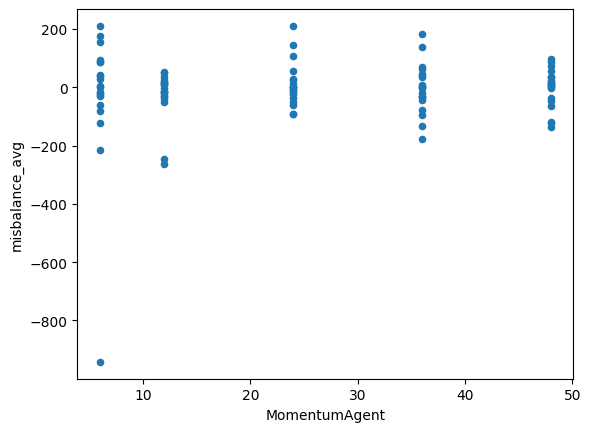

In [72]:
df_result.plot(x='MomentumAgent', y='misbalance_avg', kind='scatter')
plt.show()

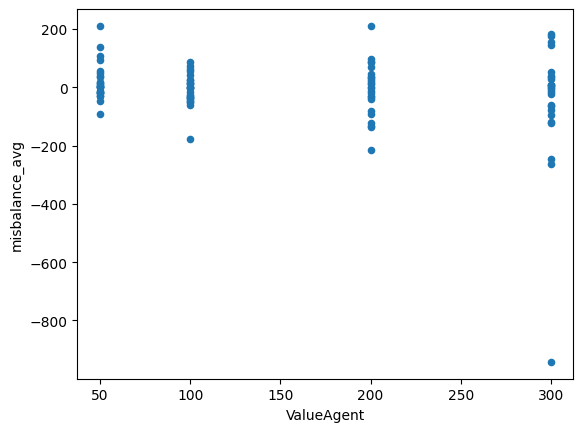

In [73]:
df_result.plot(x='ValueAgent', y='misbalance_avg', kind='scatter')
plt.show()

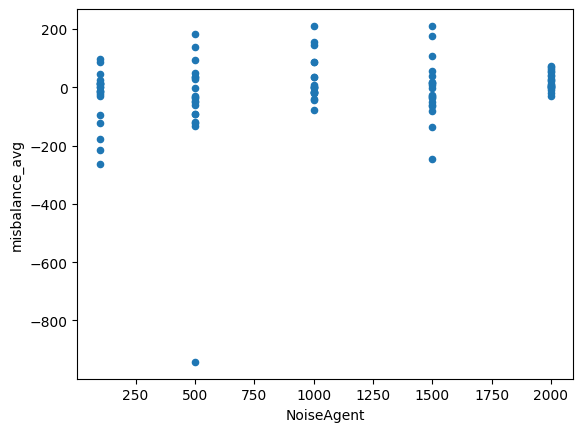

In [74]:
df_result.plot(x='NoiseAgent', y='misbalance_avg', kind='scatter')
plt.show()

### Average Imbalance

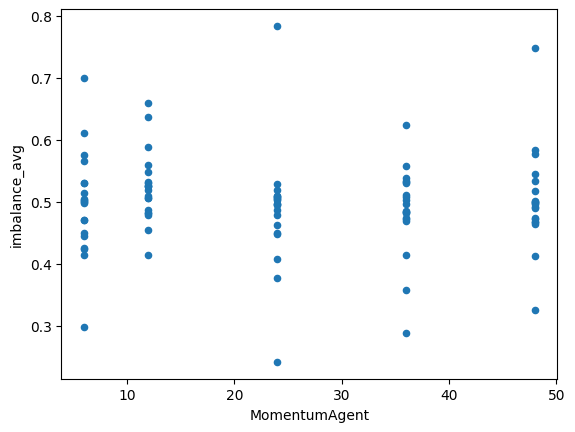

In [75]:
df_result.plot(x='MomentumAgent', y='imbalance_avg', kind='scatter')
plt.show()

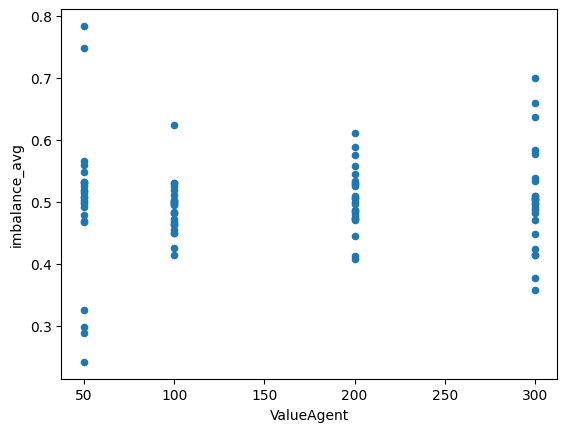

In [76]:
df_result.plot(x='ValueAgent', y='imbalance_avg', kind='scatter')
plt.show()

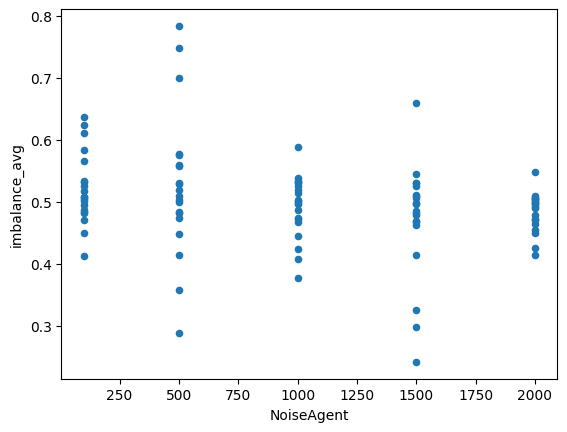

In [77]:
df_result.plot(x='NoiseAgent', y='imbalance_avg', kind='scatter')
plt.show()

### Relative Strength Index

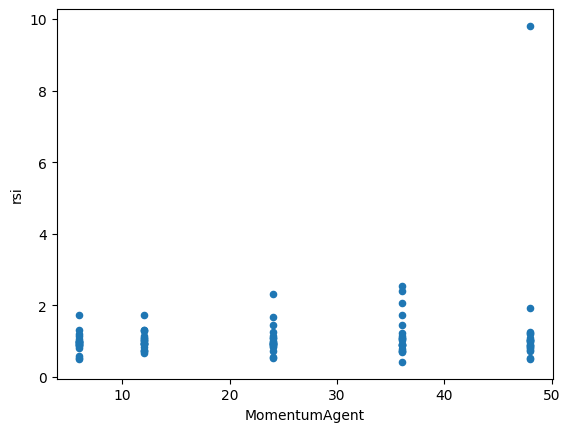

In [78]:
df_result.plot(x='MomentumAgent', y='rsi', kind='scatter')
plt.show()

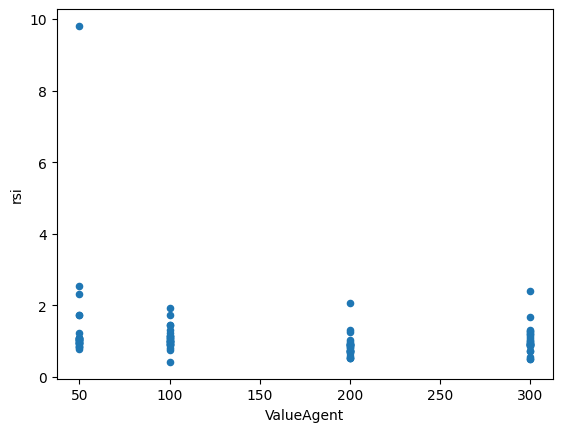

In [79]:
df_result.plot(x='ValueAgent', y='rsi', kind='scatter')
plt.show()

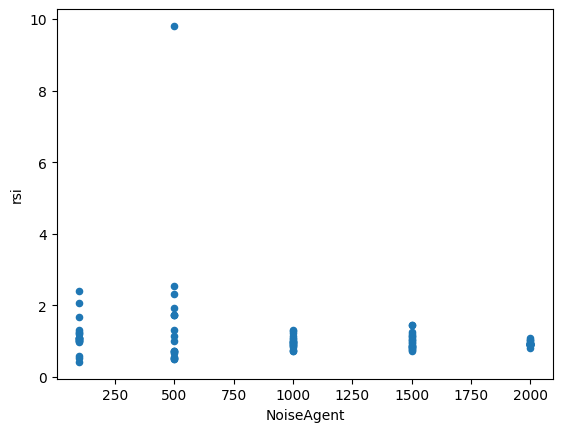

In [80]:
df_result.plot(x='NoiseAgent', y='rsi', kind='scatter')
plt.show()